# Crossing - Baseline

### **1T-10L: 1 Teams composed of 10 agents **

The Crossing Game presents a more difficult problem than the Gathering game. In place of a single food pile, there are 2 food piles separated by a fixed distance or a barrier:

* The smaller food pile is located closed to the agents, but has fewer food units than the number of agents. 
* The larger food pile has more food units than the number of agents but is located further away. The agents cannot see it unless they move away from the 1st food pile.
* If there is a river, the agent suffers a -1.0 penalty for each game step in the river.

<img src="images/Crossing01.png" width="600">

<img src="images/Crossing-river.png" width="600">

This game deals with two challenging issues that are difficult for reinforcement learning algorithms:

1. Sparce reward - the long distance an agent needs to explore with no reward to get to the 2nd food pile
2. Local Optima - the presence of the 1st smaller food pile which the agents can see

In [1]:
import os
import random
import time
import platform
import torch
import gym
import numpy as np
import pickle

# This is the Crossing game environment
from teams_env import CrossingEnv
from teams_model import *
from interface import *

import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

print("Python version: ", platform.python_version())
print("Pytorch version: {}".format(torch.__version__))
print("OpenAI Gym version: {}".format(gym.__version__))

Python version:  3.6.3
Pytorch version: 0.2.0_3
OpenAI Gym version: 0.9.2


# Training Section

## Temperature for Softmax Function

We run parameter optimization on (temp, steps/episode) to study their effectiveness on inducing agents to overcome local optima and sparce reward. This effectiveness is measure by the number of agents who gather apples in the 2nd food pile instead of the 1st pile.

In [5]:
import gym
import sys
import pickle
from collections import deque

import torch
import torch.optim as optim
from torch.autograd import Variable
import numpy as np

# Initialize agents parameters
#   10 agents - 10 learning agents, 0 trained agent, 0 random agent
num_learners = 10
num_trained = 0
num_rdn = 0

num_statics = num_trained + num_rdn
num_agents = num_learners + num_statics  

# Initialize environment
game = "Crossing"
num_actions = 8                       # 8 actions in Gathering
map_name = "food_d37_river_w1_d25"   # This is an even more difficult problem
experiment = '1T-10L/baseline/'       # 1 team of 10 agents; baseline 


# Initialize training parameters
warm_start = False
num_frames = 7      # environ observation consists of a list of stacked frames per agent
max_episodes = 3000

second_pile_x = 50  # x-coordinate of the 2nd food pile

# These trainer parameters works for Atari Breakout
gamma = 0.99  
lr = 1e-3

# Map and Parameter sets

"""
map_name = "food_d37"
parameters =[ 
            {'temp_start':1.0, 'river_penalty':-1.0, 'game_steps':300},
            {'temp_start':1.0, 'river_penalty':-1.0, 'game_steps':600},    
            {'temp_start':1.25, 'river_penalty':-1.0, 'game_steps':300},
            {'temp_start':1.25, 'river_penalty':-1.0, 'game_steps':600},    
            {'temp_start':1.5, 'river_penalty':-1.0, 'game_steps':300},
            {'temp_start':1.5, 'river_penalty':-1.0, 'game_steps':600},
            {'temp_start':1.5, 'river_penalty':-1.0, 'game_steps':1200},
            {'temp_start':2.0, 'river_penalty':-1.0, 'game_steps':300},
            {'temp_start':2.0, 'river_penalty':-1.0, 'game_steps':600},
            {'temp_start':2.0, 'river_penalty':-1.0, 'game_steps':1200},
            {'temp_start':4.0, 'river_penalty':-1.0, 'game_steps':300},
            {'temp_start':4.0, 'river_penalty':-1.0, 'game_steps':600},
            {'temp_start':4.0, 'river_penalty':-1.0, 'game_steps':1200},
            {'temp_start':8.0, 'river_penalty':-1.0, 'game_steps':300},
            {'temp_start':8.0, 'river_penalty':-1.0, 'game_steps':600},
            {'temp_start':8.0, 'river_penalty':-1.0, 'game_steps':1200}
            ]
"""

map_name = "food_d37_river_w1_d25"   # This is an even more difficult problem
parameters =[ 
            {'temp_start':1.0, 'river_penalty':-1.0, 'game_steps':300},
            {'temp_start':1.25, 'river_penalty':-1.0, 'game_steps':300},
            {'temp_start':2.0, 'river_penalty':-1.0, 'game_steps':300},
            {'temp_start':4.0, 'river_penalty':-1.0, 'game_steps':300},
            ]

temp_end = 1.0   # temp parameter is annealed from the value stored in parameters['temp_start'] to 1.0 

log_interval = 200
save_interval = 500


# The main code starts here!!!


for parameter in parameters:   # Go down the list of parameter sets
    culture = {'name':'pacifist', 'laser_penalty':-1.0}

    start = time.clock()  # time the training
   
    temp_start = parameter['temp_start']
    river_penalty = parameter['river_penalty']
    max_frames = parameter['game_steps']

    # Data structure for agents
    agents = []
    actions = []
    log_probs = []
    tags = []
    rewards = []
    optimizers = []

    # Cold start
    if warm_start is False:
   
        # Initialize learner agents, then load static agents (trained followed by random)
        for i in range(num_learners):
            print("Learner agent {}".format(i))
            agents.append(Policy(num_frames, num_actions, i)) # No weights loaded for learning agent
            optimizers.append(optim.Adam(agents[i].parameters(), lr=lr))
        
            # set up optimizer - this works for Atari Breakout
            # optimizers.append(optim.RMSprop(agents[i].parameters(), lr=lr, weight_decay=0.1)) 
        
        for i in range(num_learners, num_learners+num_trained):
            print ("Learning with trained agents - not implemented yet!")
            raise
            """
            Disable for now! No need to train with trained agents.
            agents.append(Policy(num_frames, num_actions, i))
            agents[i].load_weights()         # load weight for static agent        
            """
        for i in range(num_learners+num_trained, num_agents):
            print("Load random agent {}".format(i))
            agents.append(Rdn_Policy())

    
        # Initialize all agent data
        actions = [0 for i in range(num_agents)]
        log_probs = [0 for i in range(num_agents)]
        tags = [0 for i in range(num_agents)]
        rewards = [0 for i in range(num_agents)]

        # Keep track of rewards learned by learners
        episode_reward = [0 for i in range(num_learners)]   # reward for an episode
        running_reward = [None for i in range(num_learners)]   # running average
        running_rewards = [[] for i in range(num_learners)]   # history of running averages
        best_reward = [0 for i in range(num_learners)]    # best running average (for storing best_model)
        
        # Keep track of num learners who has crossed over to the 2nd food pile
        crossed = [0 for i in range(num_learners)]      # whether an agent has crossed to the 2nd food pile  
        episode_crossed = 0                             # num learners who has crossed for an episode
        running_crossed = None         # running average
        running_crossed_hist = []   # history of running averages

        # This is to support warm start for training
        prior_eps = 0

    # Warm start
    if warm_start:
        print ("Cannot warm start")
        raise
    
        """
        # Disable for now!  Need to ensure model can support training on GPU and game playing
        # on both CPU and GPU.
    
        data_file = 'results/{}.p'.format(game)

        try:
            with open(data_file, 'rb') as f:
                running_rewards = pickle.load(f)
                running_reward = running_rewards[-1]

            prior_eps = len(running_rewards)

            model_file = 'saved_models/actor_critic_{}_ep_{}.p'.format(game, prior_eps)
            with open(model_file, 'rb') as f:
                # Model Save and Load Update: Include both model and optim parameters
                saved_model = pickle.load(f)
                model, optimizer = saved_model

        except OSError:
            print('Saved file not found. Creating new cold start model.')
            model = Policy(input_channels=num_frames, num_actions=num_actions)
            optimizer = optim.RMSprop(model.parameters(), lr=lr,
                                      weight_decay=0.1)
            running_rewards = []
            prior_eps = 0
        """

    # Establish tribal association

    tribes = []
    tribes.append(Tribe(name='Vikings',color='blue', culture=culture, \
                    agents=[agents[0], agents[1], agents[2], agents[3], agents[4], \
                           agents[5], agents[6], agents[7], agents[8], agents[9]]))
    
    # tribes.append(Tribe(name='Saxons', color='red', culture=culture, \
    #                agents=[agents[4], agents[5], agents[6], agents[7]]))
    # tribes.append(Tribe(name='Franks', color='purple', culture=culture, \
    #                agents=[agents[8], agents[9], agents[10], agents[11]]))
    # tribes.append(Tribe(name='Crazies', color='yellow', agents=[agents[9]]))   # random agents are crazy!!!


    # Set up agent and tribe info to pass into env
    agent_colors = [agent.color for agent in agents]
    agent_tribes = [agent.tribe for agent in agents]
    tribe_names = [tribe.name for tribe in tribes]
    
    env = CrossingEnv(n_agents=num_agents,agent_colors=agent_colors, agent_tribes=agent_tribes, \
                        map_name=map_name, river_penalty=river_penalty, tribes=tribe_names)    
    
    cuda = torch.cuda.is_available()

    if cuda:
        for i in range(num_learners):    # Learning agents need to utilize GPU
            agents[i].cuda()

        
    for ep in range(max_episodes):
    
        print('.', end='')  # To show progress
    
        # Anneal temperature from temp_start to temp_end
        for i in range(num_learners):    # For learning agents
            agents[i].temperature = max(temp_end, temp_start - (temp_start - temp_end) * (ep / max_episodes))

        env_obs = env.reset()  # Env return observations

        # For Debug only
        # print (len(env_obs))
        # print (env_obs[0].shape)
    
        # Unpack observations into data structure compatible with agent Policy
        agents_obs = unpack_env_obs(env_obs)

        for i in range(num_learners):    # Reset agent info - laser tag statistics
            agents[i].reset_info()   

        # For Debug only
        # print (len(agents_obs))
        # print (agents_obs[0].shape)
    
        """
        For now, we do not stack observations, and we do not implement LSTM
    
        state = np.stack([state]*num_frames)

        # LSTM change - reset LSTM hidden units when episode begins
        cx = Variable(torch.zeros(1, 256))
        hx = Variable(torch.zeros(1, 256))
        if cuda:
            cx = cx.cuda()
            hx = hx.cuda()
        """

        # Initialize reward and agents crossed counters
        episode_reward = [0 for i in range(num_learners)]   # reward for an episode
        crossed = [0 for i in range(num_learners)]      # whether an agent has crossed to the 2nd food pile  
        episode_crossed = 0                             # num learners who has crossed for an episode

    
        for frame in range(max_frames):

            """
            For now, we do not implement LSTM
            # Select action
            # LSTM Change: Need to cycle hx and cx thru select_action
            action, log_prob, value, (hx,cx)  = select_action(model, state, (hx,cx), cuda)        
            """

            for i in range(num_learners):    # For learning agents
                actions[i], log_probs[i] = select_action(agents[i], agents_obs[i], cuda)
                if actions[i] is 6:
                    tags[i] += 1   # record a tag for accessing aggressiveness
                agents[i].saved_actions.append((log_probs[i]))
            
                # Do not implement LSTM for now
                # actions[i].saved_actions.append((log_prob, value))
            
            for i in range(num_learners, num_learners+num_trained):
                print ("No trained agent exist yet!")
                raise
            for i in range(num_learners+num_trained, num_agents):   # For random agents
                actions[i] = agents[i].select_action(agents_obs[i])
                if actions[i] is 6:
                    tags[i] += 1   # record a tag for accessing aggressiveness

            # For Debug only
            # if frame % 20 == 0:
            #    print (actions) 
            #    print (log_probs)
            
            # Perform step        
            env_obs, reward, done, info = env.step(actions)
        
            """
            For Debug only
            print (env_obs)
            print (reward)
            print (done) 
            """
       
            # Unpack observations into data structure compatible with agent Policy
            agents_obs = unpack_env_obs(env_obs)
            load_info(agents, info, narrate=False)   # Load agent info for AI agents

            # For learner agents only, generate reward statistics and reward stack for policy gradient
            for i in range(num_learners):
                agents[i].rewards.append(reward[i])  # Stack rewards (for policy gradient)
                episode_reward[i] += reward[i]   # accumulate episode reward 
            
            """
            For now, we do not stack observation, may come in handy later on
        
            # Evict oldest diff add new diff to state
            next_state = np.stack([next_state]*num_frames)
            next_state[1:, :, :] = state[:-1, :, :]
            state = next_state
            """

            if any(done):
                print("Done after {} frames".format(frame))
                break

        # Keep track num of agents who gather from 2nd food pile. Note that env.consumption tracks the 
        # agent index and location of apple gathered
        for (i, loc) in env.consumption:
            if loc[0] > second_pile_x:   # If x-cood of gathered apple is beyond a preset value, it is
                                         # in the 2nd pile
                crossed[i] = 1
        episode_crossed = sum(crossed)   # sum up the num agents who crossed to 2nd pile for the episode
                
        # Update reward and crossed statistics for learners
        for i in range(num_learners):
            if running_reward[i] is None:
                running_reward[i] = episode_reward[i]
            running_reward[i] = running_reward[i] * 0.99 + episode_reward[i] * 0.01
            running_rewards[i].append(running_reward[i])
            
        if running_crossed is None:
            running_crossed = episode_crossed
        running_crossed = running_crossed * 0.99 + episode_crossed * 0.01
        running_crossed_hist.append(running_crossed)
                
        # Track Episode #, temp and highest frames/episode
        if (ep+prior_eps+1) % log_interval == 0: 
            verbose_str = '\nEpisode {} complete'.format(ep+prior_eps+1)
            # verbose_str += '\tTemp = {:.4}'.format(model.temperature)
            print(verbose_str)
    
            # Display rewards and running rewards for learning agents
            for i in range(num_learners):
                verbose_str = 'Learner:{}'.format(i)
                verbose_str += '\tReward total:{}'.format(episode_reward[i])
                verbose_str += '\tRunning mean: {:.4}'.format(running_reward[i])
                verbose_str += '\tNum agents crossed: {}'.format(episode_crossed)
                verbose_str += '\tRunning mean: {:.4}'.format(running_crossed)
                print(verbose_str)
    
        # Update model
        total_norms = finish_episode(agents[0:num_learners], optimizers[0:num_learners], gamma, cuda)

        if (ep+prior_eps+1) % log_interval == 0:
            print('Max Norms = ',["%0.2f" % i for i in total_norms])
        
        if (ep+prior_eps+1) % save_interval == 0: 
            for i in range(num_learners):
                model_dir = 'models/' + experiment + map_name
                results_dir = 'results/' + experiment + map_name

                model_file = model_dir+'/{}/t{}_rp{}_{}gs/MA{}_{}_ep{}.p'.format(culture['name'], \
                        temp_start, river_penalty, max_frames, \
                        i, game, ep+prior_eps+1)
                data_file = results_dir+'/{}/t{}_rp{}_{}gs/MA{}_{}.p'.format(culture['name'], \
                        temp_start, river_penalty, max_frames, \
                        i, game)

                os.makedirs(os.path.dirname(model_file), exist_ok=True)
                os.makedirs(os.path.dirname(data_file), exist_ok=True)
                
                with open(model_file, 'wb') as f:
                    # Model Save and Load Update: Include both model and optim parameters 
                    pickle.dump((agents[i].cpu(), optimizers[i]), f)

                if cuda:
                    agents[i] = agents[i].cuda()

                with open(data_file, 'wb') as f:
                    pickle.dump(running_rewards[i], f)    
             
            crossed_file = results_dir+'/{}/t{}_rp{}_{}gs/Crossed.p'.format(culture['name'], \
                        temp_start, river_penalty, max_frames)
            os.makedirs(os.path.dirname(crossed_file), exist_ok=True)
            with open(crossed_file, 'wb') as f:
                    pickle.dump(running_crossed_hist, f)
    
    end = time.clock()
    print('\nTraining time: {:.2f} min'.format((end-start)/60.0))
            
    env.close()  # Close the environment

Learner agent 0
Learner agent 1
Learner agent 2
Learner agent 3
Learner agent 4
Learner agent 5
Learner agent 6
Learner agent 7
Learner agent 8
Learner agent 9
........................................................................................................................................................................................................
Episode 200 complete
Learner:0	Reward total:2	Running mean: -0.0784	Num agents crossed: 0	Running mean: 0.00951
Learner:1	Reward total:0	Running mean: 0.3547	Num agents crossed: 0	Running mean: 0.00951
Learner:2	Reward total:0	Running mean: 0.11	Num agents crossed: 0	Running mean: 0.00951
Learner:3	Reward total:1	Running mean: 0.7575	Num agents crossed: 0	Running mean: 0.00951
Learner:4	Reward total:-20.0	Running mean: 0.01454	Num agents crossed: 0	Running mean: 0.00951
Learner:5	Reward total:0	Running mean: -0.3258	Num agents crossed: 0	Running mean: 0.00951
Learner:6	Reward total:0	Running mean: -0.3308	Num agents crossed: 0	Runn

Max Norms =  ['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '144.93', '41.57', '4.32', '2.20']
........................................................................................................................................................................................................
Episode 1600 complete
Learner:0	Reward total:0	Running mean: 2.177e-05	Num agents crossed: 0	Running mean: 0.179
Learner:1	Reward total:0	Running mean: 3.119e-05	Num agents crossed: 0	Running mean: 0.179
Learner:2	Reward total:0	Running mean: -0.007003	Num agents crossed: 0	Running mean: 0.179
Learner:3	Reward total:1	Running mean: 5.301	Num agents crossed: 0	Running mean: 0.179
Learner:4	Reward total:16	Running mean: 9.016	Num agents crossed: 0	Running mean: 0.179
Learner:5	Reward total:0	Running mean: 0.002173	Num agents crossed: 0	Running mean: 0.179
Learner:6	Reward total:0	Running mean: 5.033	Num agents crossed: 0	Running mean: 0.179
Learner:7	Reward total:18	Running mean: 15.85	Num agent

Max Norms =  ['0.00', '0.00', '0.00', '0.00', '5.41', '0.00', '0.00', '11.75', '0.40', '1.06']
........................................................................................................................................................................................................
Episode 3000 complete
Learner:0	Reward total:0	Running mean: 1.687e-11	Num agents crossed: 0	Running mean: 0.0001889
Learner:1	Reward total:0	Running mean: -0.01013	Num agents crossed: 0	Running mean: 0.0001889
Learner:2	Reward total:0	Running mean: -5.427e-09	Num agents crossed: 0	Running mean: 0.0001889
Learner:3	Reward total:18	Running mean: 14.12	Num agents crossed: 0	Running mean: 0.0001889
Learner:4	Reward total:16	Running mean: 7.744	Num agents crossed: 0	Running mean: 0.0001889
Learner:5	Reward total:0	Running mean: 1.684e-09	Num agents crossed: 0	Running mean: 0.0001889
Learner:6	Reward total:0	Running mean: 0.005428	Num agents crossed: 0	Running mean: 0.0001889
Learner:7	Reward total:0

Max Norms =  ['0.00', '0.00', '0.00', '4.91', '0.00', '0.00', '0.00', '0.00', '16.32', '48.99']
........................................................................................................................................................................................................
Episode 1400 complete
Learner:0	Reward total:0	Running mean: 0.07103	Num agents crossed: 0	Running mean: 0.4465
Learner:1	Reward total:0	Running mean: 1.231	Num agents crossed: 0	Running mean: 0.4465
Learner:2	Reward total:0	Running mean: 4.101	Num agents crossed: 0	Running mean: 0.4465
Learner:3	Reward total:16	Running mean: 7.978	Num agents crossed: 0	Running mean: 0.4465
Learner:4	Reward total:-1.0	Running mean: 0.03028	Num agents crossed: 0	Running mean: 0.4465
Learner:5	Reward total:0	Running mean: 5.757	Num agents crossed: 0	Running mean: 0.4465
Learner:6	Reward total:0	Running mean: 2.016	Num agents crossed: 0	Running mean: 0.4465
Learner:7	Reward total:0	Running mean: 18.14	Num agents c

Max Norms =  ['0.00', '160.57', '15.47', '0.61', '0.00', '38.95', '0.00', '0.00', '0.00', '1.17']
........................................................................................................................................................................................................
Episode 2800 complete
Learner:0	Reward total:0	Running mean: 0.001451	Num agents crossed: 1	Running mean: 1.003
Learner:1	Reward total:104.0	Running mean: 92.41	Num agents crossed: 1	Running mean: 1.003
Learner:2	Reward total:18	Running mean: 15.59	Num agents crossed: 1	Running mean: 1.003
Learner:3	Reward total:18	Running mean: 14.76	Num agents crossed: 1	Running mean: 1.003
Learner:4	Reward total:0	Running mean: 0.009588	Num agents crossed: 1	Running mean: 1.003
Learner:5	Reward total:0	Running mean: 7.266	Num agents crossed: 1	Running mean: 1.003
Learner:6	Reward total:0	Running mean: 5.549	Num agents crossed: 1	Running mean: 1.003
Learner:7	Reward total:0	Running mean: 0.7291	Num agents c

Max Norms =  ['0.00', '0.00', '0.00', '16.72', '0.00', '0.00', '97.14', '153.20', '41.46', '32.74']
........................................................................................................................................................................................................
Episode 1200 complete
Learner:0	Reward total:17	Running mean: 2.031	Num agents crossed: 1	Running mean: 0.6633
Learner:1	Reward total:0	Running mean: 0.6702	Num agents crossed: 1	Running mean: 0.6633
Learner:2	Reward total:0	Running mean: 0.5909	Num agents crossed: 1	Running mean: 0.6633
Learner:3	Reward total:0	Running mean: 6.349	Num agents crossed: 1	Running mean: 0.6633
Learner:4	Reward total:0	Running mean: 14.38	Num agents crossed: 1	Running mean: 0.6633
Learner:5	Reward total:0	Running mean: 0.1418	Num agents crossed: 1	Running mean: 0.6633
Learner:6	Reward total:73.0	Running mean: 23.86	Num agents crossed: 1	Running mean: 0.6633
Learner:7	Reward total:0	Running mean: -0.1212	Num age

Max Norms =  ['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.49', '0.00', '0.43', '0.04']
........................................................................................................................................................................................................
Episode 2600 complete
Learner:0	Reward total:0	Running mean: 0.05044	Num agents crossed: 0	Running mean: 0.04255
Learner:1	Reward total:0	Running mean: 0.02289	Num agents crossed: 0	Running mean: 0.04255
Learner:2	Reward total:0	Running mean: 0.02286	Num agents crossed: 0	Running mean: 0.04255
Learner:3	Reward total:0	Running mean: 0.006127	Num agents crossed: 0	Running mean: 0.04255
Learner:4	Reward total:0	Running mean: 0.3243	Num agents crossed: 0	Running mean: 0.04255
Learner:5	Reward total:0	Running mean: 0.9615	Num agents crossed: 0	Running mean: 0.04255
Learner:6	Reward total:17	Running mean: 17.78	Num agents crossed: 0	Running mean: 0.04255
Learner:7	Reward total:0	Running mean: 0.001277	

Max Norms =  ['0.00', '0.00', '59.85', '78.35', '116.20', '117.21', '25.43', '41.42', '96.64', '64.03']
........................................................................................................................................................................................................
Episode 1000 complete
Learner:0	Reward total:0	Running mean: -0.1164	Num agents crossed: 0	Running mean: 0.02664
Learner:1	Reward total:0	Running mean: 0.00406	Num agents crossed: 0	Running mean: 0.02664
Learner:2	Reward total:1	Running mean: 0.484	Num agents crossed: 0	Running mean: 0.02664
Learner:3	Reward total:0	Running mean: -0.3127	Num agents crossed: 0	Running mean: 0.02664
Learner:4	Reward total:0	Running mean: 1.723	Num agents crossed: 0	Running mean: 0.02664
Learner:5	Reward total:0	Running mean: 6.977	Num agents crossed: 0	Running mean: 0.02664
Learner:6	Reward total:0	Running mean: 14.75	Num agents crossed: 0	Running mean: 0.02664
Learner:7	Reward total:17	Running mean: 8.82

Max Norms =  ['0.00', '0.00', '0.00', '0.00', '2.92', '0.00', '0.00', '0.00', '33.69', '0.00']
........................................................................................................................................................................................................
Episode 2400 complete
Learner:0	Reward total:0	Running mean: 0.04519	Num agents crossed: 0	Running mean: 0.0004248
Learner:1	Reward total:0	Running mean: 3.147e-09	Num agents crossed: 0	Running mean: 0.0004248
Learner:2	Reward total:0	Running mean: 6.483e-06	Num agents crossed: 0	Running mean: 0.0004248
Learner:3	Reward total:0	Running mean: 0.007582	Num agents crossed: 0	Running mean: 0.0004248
Learner:4	Reward total:18	Running mean: 11.54	Num agents crossed: 0	Running mean: 0.0004248
Learner:5	Reward total:0	Running mean: 0.3071	Num agents crossed: 0	Running mean: 0.0004248
Learner:6	Reward total:0	Running mean: 6.923	Num agents crossed: 0	Running mean: 0.0004248
Learner:7	Reward total:0	Runni

## Graphs

This cell block plots the learning curves of:

* Running rewards (apples gathered) 
* Num of agents who have crossed over to the 2nd food pile

for teams trained under various parameter sets of (starting temp, game steps). 

Load AI agent 0
Load AI agent 1
Load AI agent 2
Load AI agent 3
Load AI agent 4
Load AI agent 5
Load AI agent 6
Load AI agent 7
Load AI agent 8
Load AI agent 9
results/1T-10L/baseline/food_d37_river_w1_d25/pacifist/t1.0_rp-1.0_300gs/
Final Running Reward - MA0 Ind Reward: 0.000
Final Running Reward - MA1 Ind Reward: -0.010
Final Running Reward - MA2 Ind Reward: -0.000
Final Running Reward - MA3 Ind Reward: 14.124
Final Running Reward - MA4 Ind Reward: 7.744
Final Running Reward - MA5 Ind Reward: 0.000
Final Running Reward - MA6 Ind Reward: 0.005
Final Running Reward - MA7 Ind Reward: 12.703
Final Running Reward - MA8 Ind Reward: 1.353
Final Running Reward - MA9 Ind Reward: 18.951
Final Running Reward - All Agents: 54.870


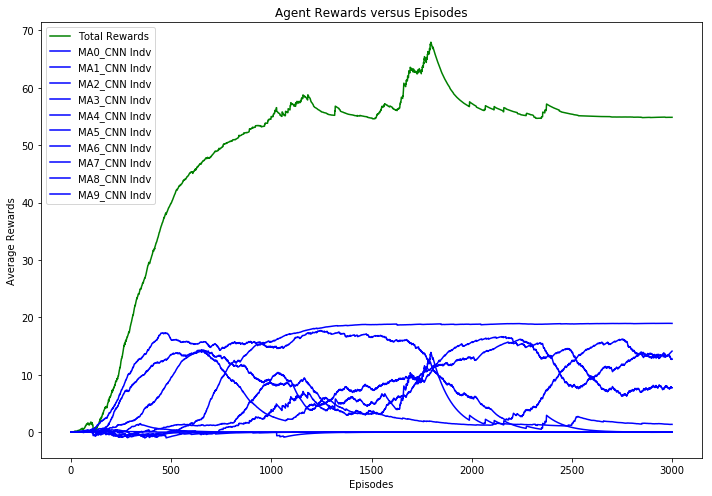

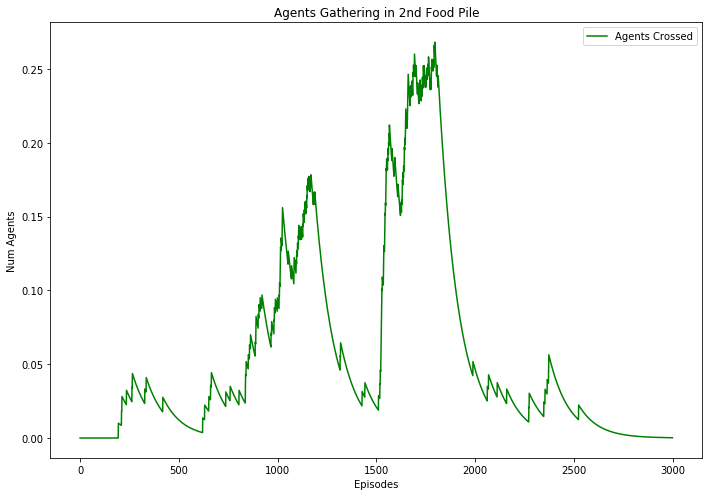

results/1T-10L/baseline/food_d37_river_w1_d25/pacifist/t1.25_rp-1.0_300gs/
Final Running Reward - MA0 Ind Reward: 0.803
Final Running Reward - MA1 Ind Reward: 99.504
Final Running Reward - MA2 Ind Reward: 13.978
Final Running Reward - MA3 Ind Reward: 16.444
Final Running Reward - MA4 Ind Reward: 0.063
Final Running Reward - MA5 Ind Reward: 11.014
Final Running Reward - MA6 Ind Reward: 0.877
Final Running Reward - MA7 Ind Reward: 0.588
Final Running Reward - MA8 Ind Reward: 0.054
Final Running Reward - MA9 Ind Reward: 10.090
Final Running Reward - All Agents: 153.416


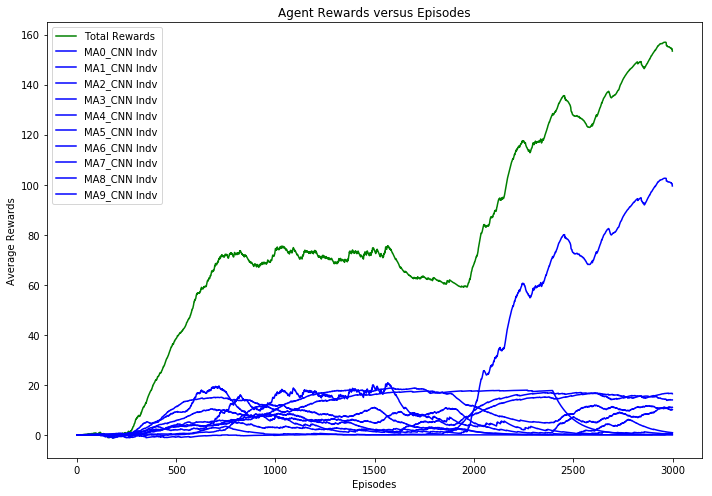

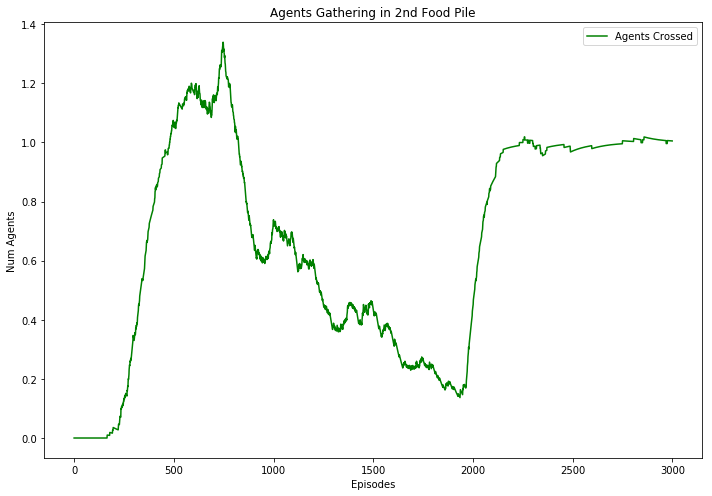

results/1T-10L/baseline/food_d37_river_w1_d25/pacifist/t2.0_rp-1.0_300gs/
Final Running Reward - MA0 Ind Reward: 0.004
Final Running Reward - MA1 Ind Reward: 0.000
Final Running Reward - MA2 Ind Reward: 0.000
Final Running Reward - MA3 Ind Reward: 0.010
Final Running Reward - MA4 Ind Reward: 0.020
Final Running Reward - MA5 Ind Reward: 0.725
Final Running Reward - MA6 Ind Reward: 17.010
Final Running Reward - MA7 Ind Reward: 0.000
Final Running Reward - MA8 Ind Reward: 16.968
Final Running Reward - MA9 Ind Reward: 19.982
Final Running Reward - All Agents: 54.720


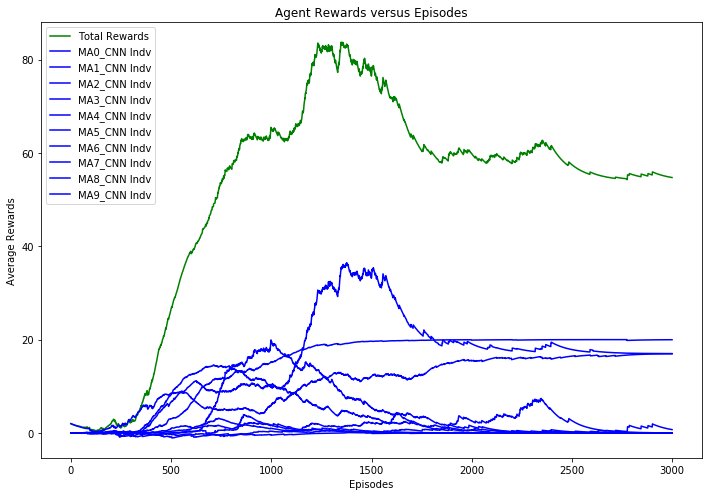

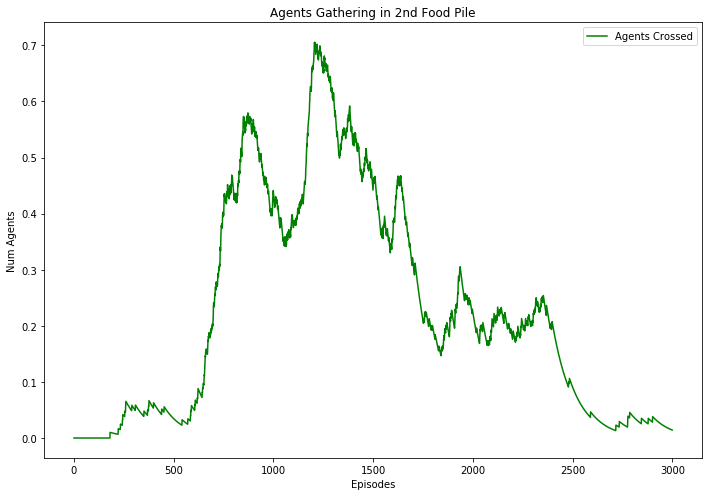

results/1T-10L/baseline/food_d37_river_w1_d25/pacifist/t4.0_rp-1.0_300gs/
Final Running Reward - MA0 Ind Reward: 0.007
Final Running Reward - MA1 Ind Reward: 0.000
Final Running Reward - MA2 Ind Reward: 0.000
Final Running Reward - MA3 Ind Reward: 0.000
Final Running Reward - MA4 Ind Reward: 17.764
Final Running Reward - MA5 Ind Reward: 0.001
Final Running Reward - MA6 Ind Reward: 0.068
Final Running Reward - MA7 Ind Reward: 0.124
Final Running Reward - MA8 Ind Reward: 17.922
Final Running Reward - MA9 Ind Reward: 18.007
Final Running Reward - All Agents: 53.893


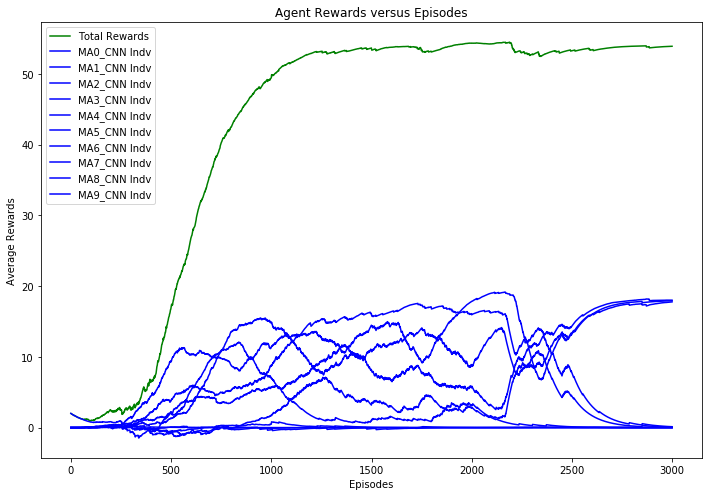

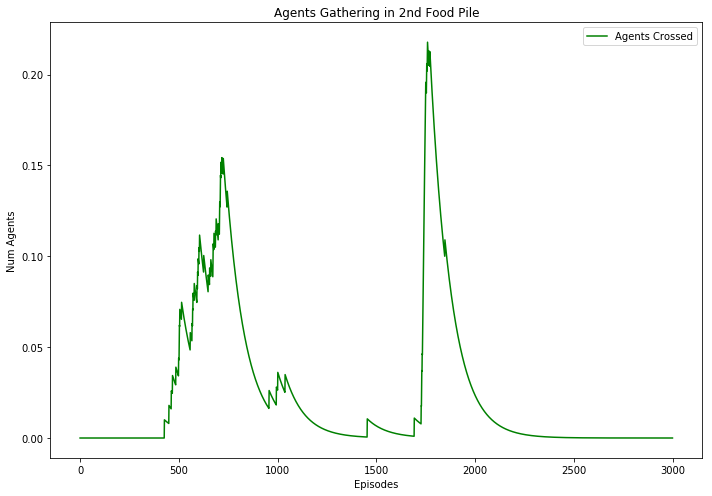

In [2]:
game = 'Crossing'

"""
############# EXPERIMENT = PACIFIST #######################
############# 1T10L/Baseline , map = food_d37 #############
dir_names = [
            "results/1T-10L/baseline/food_d37/pacifist/t1.0_rp-1.0_300gs/",
            "results/1T-10L/baseline/food_d37/pacifist/t1.0_rp-1.0_600gs/",
            "results/1T-10L/baseline/food_d37/pacifist/t1.25_rp-1.0_300gs/",
            "results/1T-10L/baseline/food_d37/pacifist/t1.25_rp-1.0_600gs/",
            "results/1T-10L/baseline/food_d37/pacifist/t1.5_rp-1.0_300gs/",
            "results/1T-10L/baseline/food_d37/pacifist/t1.5_rp-1.0_600gs/",
            "results/1T-10L/baseline/food_d37/pacifist/t1.5_rp-1.0_1200gs/",
            "results/1T-10L/baseline/food_d37/pacifist/t2.0_rp-1.0_300gs/",
            "results/1T-10L/baseline/food_d37/pacifist/t2.0_rp-1.0_600gs/",
            "results/1T-10L/baseline/food_d37/pacifist/t2.0_rp-1.0_1200gs/",
            "results/1T-10L/baseline/food_d37/pacifist/t4.0_rp-1.0_300gs/",
            "results/1T-10L/baseline/food_d37/pacifist/t4.0_rp-1.0_600gs/",
            "results/1T-10L/baseline/food_d37/pacifist/t4.0_rp-1.0_1200gs/",
            "results/1T-10L/baseline/food_d37/pacifist/t8.0_rp-1.0_300gs/",
            "results/1T-10L/baseline/food_d37/pacifist/t8.0_rp-1.0_600gs/",
            "results/1T-10L/baseline/food_d37/pacifist/t8.0_rp-1.0_1200gs/",
]

num_learners = 10
num_tribes = 1

# Cultural parameter search
culture = 'pacifist'

"""


############# EXPERIMENT = PACIFIST ###################################
############# 1T10L/Baseline, map = food_d37_river_w1_d25 #############
dir_names = [
            "results/1T-10L/baseline/food_d37_river_w1_d25/pacifist/t1.0_rp-1.0_300gs/",
            "results/1T-10L/baseline/food_d37_river_w1_d25/pacifist/t1.25_rp-1.0_300gs/",
            "results/1T-10L/baseline/food_d37_river_w1_d25/pacifist/t2.0_rp-1.0_300gs/",
            "results/1T-10L/baseline/food_d37_river_w1_d25/pacifist/t4.0_rp-1.0_300gs/",

]

num_learners = 10
num_tribes = 1

# Cultural parameter search
culture = 'pacifist'

agents = []
for i in range(num_learners):
    print("Load AI agent {}".format(i))
    agents.append(Policy(7, 8, i))

# agents.append(Rdn_Policy())

# Establish tribal association
tribes = []
tribes.append(Tribe(name='Vikings',color='blue', culture=culture, \
                    agents=[agents[0], agents[1], agents[2], agents[3], agents[4], \
                           agents[5], agents[6], agents[7], agents[8], agents[9]]))

# 10 agents in 1 tribes
agent_colors = [agent.color for agent in agents]
agent_tribes = [agent.tribe for agent in agents]

for dir_name in dir_names:
    print (dir_name)
    data = [[] for i in range(num_learners)]

    # Load rewards
    for i in range(num_learners):
        data_file = dir_name+'MA{}_{}.p'.format(i, game)
        with open(data_file, 'rb') as f:
            data[i] = pickle.load(f)
    
    crossed_file = dir_name+'Crossed.p'.format(i, game)
    with open(crossed_file, 'rb') as f:
            crossed = pickle.load(f)
            
    total = [sum(x) for x in zip(*data)]

    for i in range(num_learners):
        print('Final Running Reward - MA{} Ind Reward: {:.3f}'.format(i, data[i][-1]))
    
    print('Final Running Reward - All Agents: {:.3f}'.format(total[-1]))

    plt.figure(figsize=(10, 7))
    plt.plot(total, label='Total Rewards', color='green')
    for i in range(num_learners):
        plt.plot(data[i], label='MA{}_CNN Indv'.format(i), color=agent_colors[i])

    plt.title('Agent Rewards versus Episodes')
    plt.xlabel('Episodes')
    plt.ylabel('Average Rewards')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(10, 7))
    plt.plot(crossed, label='Agents Crossed', color='green')

    plt.title('Agents Gathering in 2nd Food Pile')
    plt.xlabel('Episodes')
    plt.ylabel('Num Agents')
    plt.legend()
    plt.tight_layout()
    plt.show()